In [1]:
import pandas as pd
import numpy as np

file = "../data/facebook.csv"

df = pd.read_csv(file, low_memory=False, parse_dates=[0])

/var/folders/yw/m_924cdx5sv965q742rtv_p40000gn/T/ipykernel_50866/2669788710.py:6: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv(file, low_memory=False, parse_dates=[0])


In [2]:
%cd ..

/Users/mac/Documents/development/Hack_the_feed


In [3]:
from src.clean_data import clean_df

In [4]:
new_df = clean_df(df)
new_df.index = pd.to_datetime(new_df.index)
new_df.head()

,Content Type,Sent by,Link,Post,Linked Content,Impressions,Organic Impressions,Viral Impressions,Non-viral Impressions,Paid Impressions,...,Unique Video Views,Unique Organic Video Views,Unique Paid Video Views,Unique 10-Second Video Views,Unique Full Video Views,Unique Organic 95% Video Views,Unique Paid 95% Video Views,Tags,Time,Time Period
Date,,,,,,,,,,,,,,,,,,,,,
2013-01-15,Link,,https://www.facebook.com/253788558082460/posts...,NaN,https://www.facebook.com/253788558082460/posts...,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16:25:00,afternoon
2013-01-16,Photo,,https://www.facebook.com/media/set/?set=a.2714...,NaN,https://www.facebook.com/StanbicIBTC/photos/a....,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16:51:00,afternoon
2013-01-16,Photo,,https://www.facebook.com/StanbicIBTC/photos/a....,NaN,https://www.facebook.com/StanbicIBTC/photos/a....,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16:58:00,afternoon
2013-01-17,Photo,,https://www.facebook.com/StanbicIBTC/photos/a....,NaN,https://www.facebook.com/StanbicIBTC/photos/a....,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17:08:00,evening
2013-02-01,Photo,,https://www.facebook.com/media/set/?set=a.2828...,NaN,https://www.facebook.com/StanbicIBTC/photos/a....,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13:24:00,afternoon


In [5]:
impressions = []
views = []
clicks = []
others = []

for col in new_df.columns:
    if "Impressions" in col or "Reach" in col:
        impressions.append(col)
    elif "Clicks" in col:
        clicks.append(col)
    elif "Views" in col:
        views.append(col)
    else:
        others.append(col)

## Impressions and Reach

In [6]:
valid_impre = new_df[(new_df["Impressions"] != 0) & ~new_df["Impressions"].isna()]

con_df = (
    valid_impre.groupby("Content Type")["Impressions"]
    .mean()
    .reset_index()
    .sort_values("Impressions")
)

In [7]:
from bokeh.io import output_notebook, export_png

output_notebook()

Loading BokehJS ...

In [8]:
from bokeh.plotting import figure, show

p = figure(
    title="Average Impression by Content Type",
    x_range=con_df["Content Type"],
    height=400,
    width=600,
    y_axis_label="Average Impression",
)

p.vbar(x=con_df["Content Type"], top=con_df["Impressions"], width=0.8)

p.y_range.start = 1000

show(p)

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.style.use("seaborn-v0_8-whitegrid")

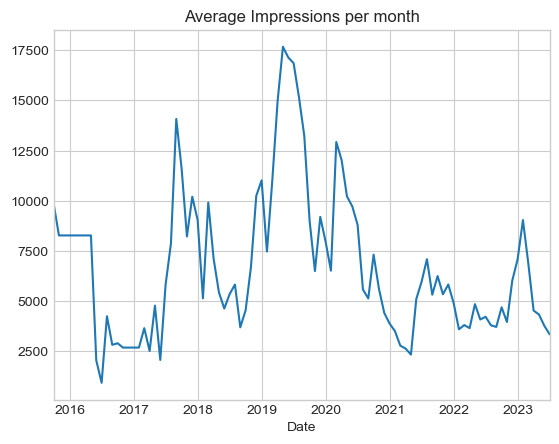

In [10]:
mmi = valid_impre["Impressions"].resample("M").mean()
ax = mmi.fillna(method="ffill").plot(title="Average Impressions per month")

plt.savefig("docs/avg_month.png")
plt.show();

In [11]:
cbt = valid_impre.groupby(["Content Type", "Time Period"])["Reach"].mean().reset_index()

time_period_order = ["morning", "afternoon", "evening"]

cbt["Time Period"] = pd.Categorical(
    cbt["Time Period"], categories=time_period_order, ordered=True
)
cbt = cbt.sort_values(["Content Type", "Time Period"])
cbt.reset_index(drop=True, inplace=True)

In [12]:
link = cbt.iloc[:3]
link.name = "Link"

photo = cbt.iloc[3:6]
photo.name = "Photo"

text = cbt.iloc[6:9]
text.name = "Text"

video = cbt.iloc[9:]
video.name = "Video"

content = (link, photo, text, video)

In [13]:
def plot_bar(df):
    p = figure(title=df.name, x_range=list(df["Time Period"]), height=300, width=400)

    p.vbar(x="Time Period", top="Reach", color="#99CCFF", source=df, width=0.8)

    p.xgrid.grid_line_color = None
    p.xaxis.major_tick_out = 0
    p.xaxis.axis_label = "Time period"
    p.yaxis.axis_label = "Average Reach"
    p.yaxis.minor_tick_out = 0
    p.yaxis.major_tick_out = 0
    p.y_range.start = 1000
    p.y_range.end = 9000

    return p

In [14]:
from bokeh.layouts import gridplot

plots = []
for c in content:
    plot = plot_bar(c)
    plots.append(plot)

layout = gridplot(plots, ncols=2, toolbar_location=None)
show(layout)